## 1 Simulation

We simulate data to showcase multiple ways of estimating the ATT for a simple 2x2 DiD model $\theta^{DiD}_{2 \times 2}$. This simulation is inspired from Arthur Heim's lecture slides available [here](https://extranet.parisschoolofeconomics.eu/docs/heim-arthur/lecture_4_introdid.pdf).

Recall $Y_{i,t}(g)$ denotes $i$'s potential outcome at time $t$ in the scenario it were to receive treatment $g$. In the $2 \times 2$ case $g \in \{0,1\}$ (treatment and control) and $t \in \{0,1\}$ (pre and post-treatment period). Hence, in the $2 \times 2$ case we have the following:

- $Y_{i,0}(0)$ - unit $i$'s potential **pre-treatment** outcome if it belonged to the **control** group 
- $Y_{i,0}(1)$ - unit $i$'s potential **pre-treatment** outcome if it belonged to the **treatment** group 
- $Y_{i,1}(0)$ - unit $i$'s potential **post-treatment** outcome if it belonged to the **control** group 
- $Y_{i,1}(1)$ - unit $i$'s potential **post-treatment** outcome if it belonged to the **treatment** group 

We only observe $Y_{i,t} = g_iY_{i,t}(1) + (1-g_i)Y_{i,t}(0)$. So if unit $i$ is never treated we see $Y_{i,t}(0)$, whereas if it were eventually treated we would see $Y_{i,t}(1)$, for $t=0,1$

In [198]:
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("fixest")
#install.packages("ggplot2")
#install.packages("sandwich")
#install.packages("lmtest")
library(dplyr)
library(tidyr)
library(ggplot2)
library(fixest) #for FE 
library(sandwich)
library(lmtest)

set.seed(666)

In [199]:
# Sample size, treatment effect and dummy 
n <- 400
TEffect <- 3
TDummy <- c(rep(0, n/2), rep(1, n/2))
id <- seq(1,n)

# Simulate pre and post-treatment outcomes 
y_pre = c(rep(0, n))
y_pre[1:(n/2)] <- 6                                     #pre-treatment observed outcomes for never-treated
y_pre[(n/2):n] <- 7                                     #pre-treatment observed outcomes for eventually-treated 

y_post = c(rep(0, n))
y_post[1:(n/2)] <- 6 + 2 + TEffect*TDummy[1:(n/2)]      #post-treatment observed outcomes for never-treated
y_post[(n/2):n] <- 7 + 2 + TEffect*TDummy[(n/2):n]      #post-treatment observed outcomes for eventually-treated

# Post-treatment +2 for both T and C units (parallel trends), plus treatment effect 

- Without any noise, treated units start at $7$ and control units at $6$ at the pre-treatment period.
- In absence of treatment *(TDummy=0)*, these values would have evolved to $9$ and $8$ respectively, parallel to one another by $+2$
- Since treatment occurs for treated units, $Y_{i,1}(1)=9+3=12$

In [200]:
# Add random noise for regression
y_pre = y_pre + rnorm(n,0,2)
y_post = y_post + rnorm(n,0,2)

We can graph the evolution of treatment and control mean outcomes, along with each period's distribution

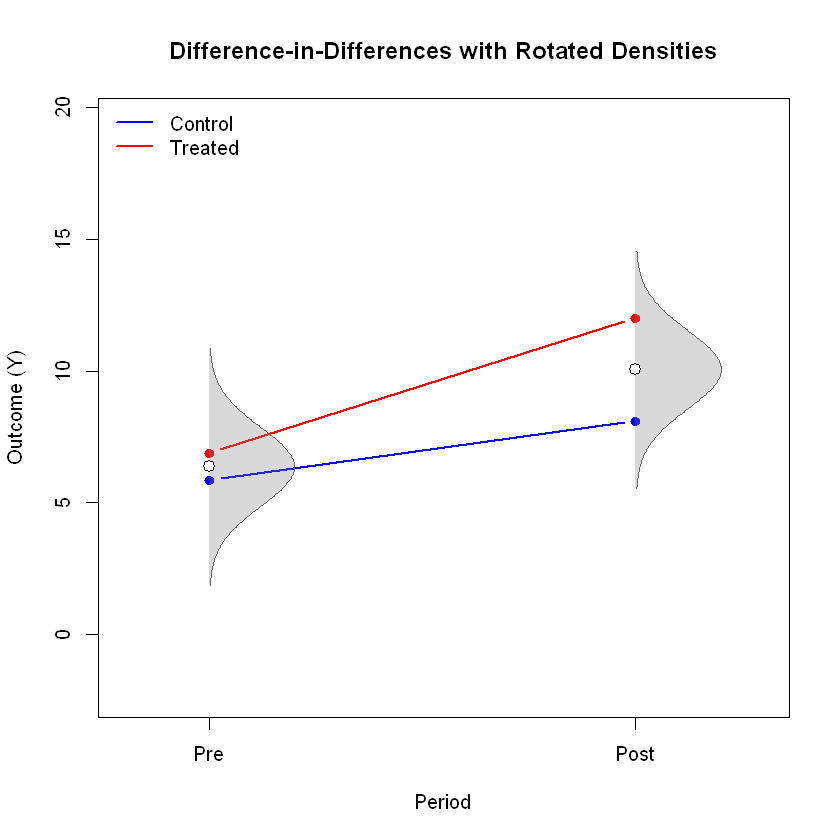

In [201]:
# Conditional means
mean_pre_control  <- mean(y_pre[TDummy == 0])
mean_post_control <- mean(y_post[TDummy == 0])
mean_pre_treated  <- mean(y_pre[TDummy == 1])
mean_post_treated <- mean(y_post[TDummy == 1])

# Unconditional means
mean_pre_uncond  <- mean(y_pre)
mean_post_uncond <- mean(y_post)

# Plot DiD lines 
plot(c(1,2), c(mean_pre_control, mean_post_control),
     type="b", pch=19, col="blue", lwd=2, xaxt="n",
     ylim=c(min(y_pre,y_post)-2, max(y_pre,y_post)+2),
     xlim=c(0.8, 2.3),  # extended to avoid cutoff
     xlab="Period", ylab="Outcome (Y)",
     main="Difference-in-Differences with Rotated Densities")

axis(1, at=c(1,2), labels=c("Pre", "Post"))
lines(c(1,2), c(mean_pre_treated, mean_post_treated),
      type="b", pch=19, col="red", lwd=2)
legend("topleft", legend=c("Control","Treated"),
       col=c("blue","red"), lwd=2, bty="n")

# Rotate density 90 degrees clockwise 
add_rotated_density <- function(x_center, y_mean, sd_y, scale=0.2, n=200, col_fill=rgb(0.5,0.5,0.5,0.3)) {
  y_seq <- seq(y_mean - 3*sd_y, y_mean + 3*sd_y, length.out = n)
  dens  <- dnorm(y_seq, mean = y_mean, sd = sd_y)
  x_vals <- x_center + dens / max(dens) * scale  # rotate 90° right (not mirrored)
  polygon(c(x_center, x_vals, x_center),
          c(min(y_seq), y_seq, max(y_seq)),
          col=col_fill, border=NA)
  lines(x_vals, y_seq, col="gray40", lwd=1.5)
}

# Add pre and post densities (semi-transparent gray)
add_rotated_density(1, mean_pre_uncond, 1.5)
add_rotated_density(2, mean_post_uncond, 1.5)

# Mark unconditional means
points(c(1,2), c(mean_pre_uncond, mean_post_uncond),
       pch=21, bg="white", cex=1.3)

In [202]:
# Data in wide format 
dfDiD <- as.data.frame(cbind(id, y_post, y_pre, TDummy))

# Reshape long 
dflong <- dfDiD %>%
  pivot_longer(cols = c(y_post, y_pre), names_to = c("period"), values_to = "Y") %>%
  mutate(time = ifelse(period == "y_post", 1, 0), period = factor(period, levels = c("y_pre", "y_post")), time_TDummy = time * TDummy) 

## 2 Estimation

### 2.1 Two-way fixed effects (TWFE)

The **Two-Way Fixed Effects (TWFE)** model is a regression-based formulation of the Difference-in-Differences (DiD) estimator that accounts for both group-specific and time-specific unobserved factors. In the simplest $2 \times 2$ setup, the model is written as  

$$Y_{it} = \lambda_t + \alpha_i + \theta (D_i \times Post_t) + \varepsilon_{it}$$

where $Y_{it}$ is the outcome for unit $i$ at time $t$, $D_i$ is a treatment indicator, $Post_t$ indicates the post-treatment period, and the interaction term $D_i \times Post_t$ captures treated units observed after treatment. The fixed effects $\alpha_i$ and $\lambda_t$ control for time-invariant group differences and aggregate time shocks, respectively. The coefficient $\theta$ represents the DiD estimator, quantifying how much the treated group’s outcome changes after treatment relative to the control group and, under the **parallel trends assumption**, identifies the **average treatment effect on the treated (ATT)**.

In our code, $Post_t$ refers to <code>time</code>, $D_i$ to <code>TDummy</code> $D_i \times Post_t$ to <code>time_TDummy</code>



In [203]:
model_twfe <- feols(Y ~ time_TDummy | id + period, data = dflong)
coef_value <- coef(model_twfe)["time_TDummy"]
se_value   <- se(model_twfe)["time_TDummy"]
p_value    <- pvalue(model_twfe)["time_TDummy"]

cat(sprintf("TWFE Estimate (ATT): %.3f\nStandard Error: %.3f\np-value: %.3f", coef_value, se_value, p_value))
#summary(model_twfe)

TWFE Estimate (ATT): 2.889
Standard Error: 0.263
p-value: 0.000

### 2.2 Canonical DiD regression

The **Canonical Difference-in-Differences (DiD)** model provides the simplest regression-based formulation of the DiD estimator in a $2 \times 2$ setting. It is specified as  

$$
Y_{it} = \beta_0 + \beta_1 \, Post_t + \beta_2 \, D_i + \theta (D_i \times Post_t ) + \varepsilon_{it}
$$  

where $Y_{it}$ is the outcome for unit $i$ at time $t$, $D_i$ is a binary indicator for the treated group, and $Post_t$ is a binary indicator for the post-treatment period. The interaction term $(D_i \times Post_t)$ identifies treated units observed after the intervention.  

In [204]:
model_ols <- lm(Y ~ time + TDummy + time_TDummy, data = dflong)
coef_value <- coef(model_ols)["time_TDummy"]
se_value   <- se(model_ols)["time_TDummy"]
p_value    <- pvalue(model_ols)["time_TDummy"]

cat(sprintf("Canonical DiD (ATT): %.3f\nStandard Error: %.3f\np-value: %.3f", coef_value, se_value, p_value))
#summary(model_ols)

Canonical DiD (ATT): 2.889
Standard Error: 0.276
p-value: 0.000

Why is our SE different from the TWFE model?

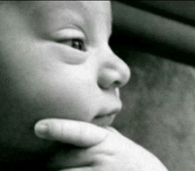

When computing SE, we need to account for the fact that each treatment unit is included twice in our regression (once for each time period). We account for this by clustering by id.  

In [205]:
vcov_cluster <- vcovCL(model_ols, cluster = ~id) #include clusters by unit id 
res <- coeftest(model_ols, vcov = vcov_cluster)

# Extract coefficient, SE, and p-value for the DiD term
coef_value <- res["time_TDummy", 1]
se_value   <- res["time_TDummy", 2]
p_value    <- res["time_TDummy", 4]

cat(sprintf("Canonical DiD (ATT): %.3f\nClustered SE (id): %.3f\np-value: %.3f",
            coef_value, se_value, p_value))

Canonical DiD (ATT): 2.889
Clustered SE (id): 0.263
p-value: 0.000

### 2.3 DiD "by hand" (optional)

In the $2 \times 2$ setup, the **Difference-in-Differences (DiD)** estimator computes the treatment effect as the difference between two average changes — one for the treated group and one for the control group. Let $\overline{Y}_{t}^{g}$ denote the average observed outcome for group $g \in \{C,T\}$ (control, treatment) at time $t \in \{0,1\}$ (pre, post).

The **DiD estimator** is then computed as:  

$$\hat{\theta}^{DiD}_{2 \times 2} = \Big(\overline{Y_{1}^T} - \overline{Y_{0}^T}\Big) - \Big(\overline{Y_{1}^C} - \overline{Y_{0}^C}\Big)$$

- The **first difference** $(\overline{Y}_{1,1} - \overline{Y}_{1,0})$ measures the change in outcomes for the **treated** group before and after treatment.  
- The **second difference** $(\overline{Y}_{0,1} - \overline{Y}_{0,0})$ measures the change in outcomes for the **control** group over the same period.  
- The DiD estimator then removes the common time trend affecting both groups, isolating the causal impact of treatment **under the parallel trends assumption**.


In [206]:
averages <- dflong %>%
  group_by(period, TDummy) %>%
  summarise(
    Ybar = mean(Y),
    sd = sd(Y),
    n = n(),
    se = sd / sqrt(n)
  )

# 2x2 Table
table_2x2 <- tibble(
  Group = c("Control", "Treated"),
  `Pre-treatment` = c(
    averages$Ybar[averages$period == "y_pre"  & averages$TDummy == 0],
    averages$Ybar[averages$period == "y_pre"  & averages$TDummy == 1]
  ),
  `Post-treatment` = c(
    averages$Ybar[averages$period == "y_post" & averages$TDummy == 0],
    averages$Ybar[averages$period == "y_post" & averages$TDummy == 1]
  )
)

averages
table_2x2

`summarise()` has grouped output by 'period'. You can override using the `.groups` argument.


period,TDummy,Ybar,sd,n,se
<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
y_pre,0,5.845545,2.166298,200,0.1531804
y_pre,1,6.867843,2.002936,200,0.1416290
y_post,0,8.093552,1.885459,200,0.1333221
y_post,1,12.004969,1.740379,200,0.1230634


Group,Pre-treatment,Post-treatment
<chr>,<dbl>,<dbl>
Control,5.845545,8.093552
Treated,6.867843,12.004969


In [207]:
# Control group
Y_C_pre  <- averages$Ybar[averages$period == "y_pre"  & averages$TDummy == 0]
Y_C_post <- averages$Ybar[averages$period == "y_post" & averages$TDummy == 0]

# Treated group
Y_T_pre  <- averages$Ybar[averages$period == "y_pre"  & averages$TDummy == 1]
Y_T_post <- averages$Ybar[averages$period == "y_post" & averages$TDummy == 1]

# Pre-post Differences
delta_C <- Y_C_post - Y_C_pre  # Control trend
delta_T <- Y_T_post - Y_T_pre  # Treated trend

# Differences in differences
ATT <- delta_T - delta_C
cat(sprintf("DiD by hand (ATT):"), ATT)

DiD by hand (ATT): 2.889118

We need to compute a standard error. One could think of doing the following:

$$
{SE}(\widehat{\theta}^{DiD}_{2 \times 2}) = \sqrt{{s_{1,T}}^2 + s_{0,T}^2 + s_{1,C}^2 + s_{0,C}^2}
$$

Where $s_{t,g} = \text{var}(y_{t,g}) / n_{t,g}$ are the standard error from the table above.

In [208]:
# Extract SEs
se_T_post <- averages$se[averages$period == "y_post" & averages$TDummy == 1]
se_T_pre  <- averages$se[averages$period == "y_pre"  & averages$TDummy == 1]
se_C_post <- averages$se[averages$period == "y_post" & averages$TDummy == 0]
se_C_pre  <- averages$se[averages$period == "y_pre"  & averages$TDummy == 0]

# Approximate SE of DiD (assuming independent groups)
SE_ATT <- sqrt(se_T_post^2 + se_T_pre^2 + se_C_post^2 + se_C_pre^2)
cat(sprintf("DiD by hand (ATT): %.3f\nStandard Error: %.3f", ATT, SE_ATT))

DiD by hand (ATT): 2.889
Standard Error: 0.276

However this SE is the same as the Canonical DiD without clustering by id. 

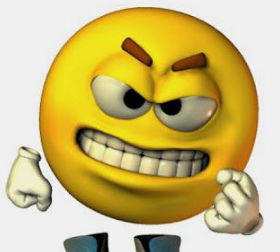

Recall $\hat{\theta}^{DiD}_{2 \times 2} = \Big(\overline{Y_{1}^T} - \overline{Y_{0}^T}\Big) - \Big(\overline{Y_{1}^C} - \overline{Y_{0}^C}\Big)$. It is clear that $\overline{Y_{1}^T}$ correlates with $\overline{Y_{0}^T}$, and $\overline{Y_{1}^C}$ correlates with $\overline{Y_{0}^C}$. We are averaging a variable for the same treatment group at two different points in time. 

To solve this, let $\Delta^T=\overline{Y_{1}^T} - \overline{Y_{0}^T}$ and $\Delta^C=\overline{Y_{1}^C} - \overline{Y_{0}^C}$. Then, to account for the within-unit correlation:

$$SE(\hat{\theta}^{DiD}_{2 \times 2}) = \sqrt{SE(\Delta^T)^2 + SE(\Delta^C)^2}$$

In [210]:
# differences
dfDiD$diff <- dfDiD$y_post - dfDiD$y_pre

# treated / control
diff_t <- dfDiD$diff[dfDiD$TDummy == 1]
diff_c <- dfDiD$diff[dfDiD$TDummy == 0]

n_t <- length(diff_t)
n_c <- length(diff_c)

# ATT
ATT <- mean(diff_t) - mean(diff_c)

# SE using variance of differences
var_d_t <- var(diff_t)      # sample variance of differences in treated
var_d_c <- var(diff_c)      # sample variance of differences in control

SE_ATT_cluster <- sqrt(var_d_t / n_t + var_d_c / n_c)
cat(sprintf("DiD by hand (ATT): %.3f\nClustered SE (id): %.3f", ATT, SE_ATT_cluster))

DiD by hand (ATT): 2.889
Clustered SE (id): 0.263

This way we get the same standard error as in the TWFE